In [1]:
name = "Caio Túlio de Deus Andrade"  # write YOUR NAME

honorPledge = "I affirm that I have not given or received any unauthorized " \
              "help on this assignment, and that this work is my own.\n"


print("\nName: ", name)
print("\nHonor pledge: ", honorPledge)


Name:  Caio Túlio de Deus Andrade

Honor pledge:  I affirm that I have not given or received any unauthorized help on this assignment, and that this work is my own.



# <font style="color:#FFFFFF;background-color:#2e4053;">MAC0460 / MAC5832 (2021)</font>
<hr>

## <font style="background-color:#abebc6">EP3: Logistic regression</font>

### Topics / concepts explored in this EP:

- Implementation of the **logistic regression algorithm**, using the gradient descent technique
- Application on binary classification of 2D examples  (i.e., $d=2$)
- Confusion matrix, effects of unbalanced classes

Complete and submit this notebook. Places to be filled are indicated with <font style="background-color: #f7dc6f">this color</font>

### Evaluation  criteria
- Correctitude of the algorithms
- Code
    - do not change the prototype of the functions
    - efficiency (you should avoid unnecessary loops; use matrix/vector computation with NumPy wherever appropriate)
    - cleanliness (do not leave any commented code or useless variables)
- Appropriateness of the answers
- File format: Complete and submit this notebook <font color="red">with the outputs of the execution</font>. **Do no change the file name.**
<hr>

### Hints
- In this notebook vectors are implemented as <tt>ndarray (n,)</tt> and not as <tt>ndarray (n,1)</tt>
- It might be wise to first make sure your implementation is correct. For instance, you can compare the results of your implementation with the ones obtained with the implementation available in <a href="https://scikit-learn.org/stable/">scikit-learn</a>. After you feel confident, paste your code in the notebook, and then run the rest of the code in the notebook.
- If you face difficulties with Keras or other libraries used in this notebook, as well as clarity issues in the exercises in this notebook, post a message in the <a href="https://edisciplinas.usp.br/mod/forum/view.php?id=3409630">Forum for discussions</a>.

# The algorithm

We will use the formulation described in the textbook (<i>Learning from data</i>, Abu-Mostafa <i>et al.</i>). Positive class label is equal to 1 and negative class label is equal to -1.

The loss (or cost) function to be minimized is
$$
E_{in}(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^{N} \ln(1 + e^{-y^{(i)} \mathbf{w}^T \mathbf{x}^{(i)}}) \tag{1}
$$

Its gradient is given by

$$\nabla E_{in}(\mathbf{w}) = - \frac{1}{N}\sum_{i=1}^{N} \frac{y^{(i)} \mathbf{x}^{(i)}}{1 + e^{y^{(i)} \mathbf{w}^T \mathbf{x}^{(i)}}}  \tag{2}$$

The logistic (sigmoid) function is
$$\sigma(z) = \frac{1}{1 + e^{-z}}  \tag{3}$$

In [2]:
# All imports

import numpy as np
import pandas as pd
import seaborn as sb

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.datasets import mnist

%matplotlib inline

# 1. Training and prediction algorithms

<br>
In the next four code cells, write the code to implement the specified functions. These functions will be used below for logistic regression training and prediction, in Sections 2 to 4. Use vectorial computation with NumPy.

## <font style="background-color: #f7dc6f">1.1. Cross-entropy loss</font>
This is Equation (1) above.

In [3]:
def cross_entropy_loss(w, X, y):
    """
    Computes the loss (equation 1)
    :param w: weight vector
    :type: np.ndarray(shape=(1+d, ))
    :param X: design matrix
    :type X: np.ndarray(shape=(N, 1+d))
    :param y: class labels
    :type y: np.ndarray(shape=(N, ))
    :return loss: loss (equation 1)
    :rtype: float
    """    
    
    ### ===> Your code begins here
   
    N, dim = X.shape
    X = X.T
    W = w.reshape((dim, 1))
    
    binary_input = y * X
    signal = W.T @ binary_input
    exp = np.log(1+np.exp(-signal.flatten()))/N
    return np.sum(exp)
    ### ===> Your code ends here


## <font style="background-color: #f7dc6f">1.2. Gradient of the cross-entropy loss</font>

This is Equation (2) above.

In [4]:
def cross_entropy_gradient(w, X, y):
    """
    Computes the gradient of the loss function (equation 2)
    :param w: weight vector
    :type: np.ndarray(shape=(1+d, ))
    :param X: design matrix
    :type X: np.ndarray(shape=(N, 1+d))
    :param y: class labels
    :type y: np.ndarray(shape=(N, ))
    :return grad: gradient (equation 2)
    :rtype: float
    """
    
    ### ===> Your code begins here
    
    N, dim = X.shape
    X = X.T
    W = w.reshape((dim, 1)) #Column 2d vector
    
    binary_input = y * X # dim, N
    signal = W.T @ binary_input # 1, N
    
    exp = np.exp(signal)
    
    div = -binary_input /((1 + exp)*N) # -> outcast; res = (3, 100)
    return np.sum(div, axis=1) #Inputs are stored as columns, so we sum it all horizontally
    ### ===> Your code ends here


## <font style="background-color: #f7dc6f">1.3 Logistic regression training</font>

The function below receives the data matrix  <tt> X (shape = (N, d))</tt> and the ouput vector <tt>y (shape = (N,))</tt>, and should return the final weight vector <tt>w (shape = (d+1,))</tt> and, optionally (when  parameter <tt>return_history = True</tt>), a list of size <tt>num_iterations+1</tt> with the cross-entropy loss values at the beginning and after each of the iterations.

Note that the data matrix needs to be extended with a column of 1's.

If <tt>w0==None</tt> it must be initialized  with <tt>w0 = np.random.normal(loc = 0, scale = 1, size = X.shape[1])</tt>


In [5]:
def normalize_vector(vector):
    """
    Computes the unit vector of a given vector.
    :param vector: any ndarray
    :rtype: ndarray
    """
    return vector/np.linalg.norm(vector)

In [75]:
def train_logistic(X, y, learning_rate = 1e-1, w0 = None,\
                        num_iterations = 1000, return_history = False):
    """
    Computes the weight vector applying the gradient descent technique
    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param y: class label
    :type y: np.ndarray(shape=(N, ))
    :return: weight vector
    :rtype: np.ndarray(shape=(1+d, ))
    :return: the history of loss values (optional)
    :rtype: list of float
    """    
    
    ### ===> Your code begins here
    N, _ = X.shape
    ones = np.ones((N, 1))
    X = np.hstack((ones, X))

    if (w0 is None):
        w0 = np.random.normal(loc = 0, scale = 1, size = X.shape[1])
    w = w0
    
    losses = []
    initial_loss = cross_entropy_loss(w, X, y)
    losses.append(initial_loss)

    for i in range(num_iterations):
        nabla = cross_entropy_gradient(w, X, y)
        v_hat =  -normalize_vector(nabla)
        w = w + learning_rate * v_hat
        if (return_history):
            losses.append(cross_entropy_loss(w, X, y))
    return [w, losses]
    ### ===> Your code ends here


## <font style="background-color: #f7dc6f">1.4. Logistic regression prediction</font>

The function in the next cell will be used to do the prediction of logistic regression. Recall that the prediction is a score in $[0,1]$, given by the sigmoid value of the linear combination.

In [51]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def predict_logistic(X, w):
    """
    Computes the logistic regression prediction
    :param X: design matrix
    :type X: np.ndarray(shape=(N,d))
    :param w: weight vector
    :rtype: np.ndarray(shape=(1+d,))
    :return: predicted classes 
    :rtype: np.ndarray(shape=(N,))
    """
    
    ### ===> Your code begins here
    N, dim = X.shape
    
    ones = np.ones((N, 1))
    X = np.hstack((ones, X))
    X = X.T
    W = w.reshape((dim+1, 1))
    signal = sigmoid(W.T @ X) # isso aqui é 1xN, tem que ser (N,)
    return signal.flatten()
    ### ===> Your code ends here


# 2. Testing on a toy dataset

## 2.1. Generate two blobs of points

In [8]:
# Create two blobs
N = 300
X, y = make_blobs(n_samples=N, centers=2, cluster_std=1, n_features=2, random_state=2)

# change labels 0 to -1
y[y==0] = -1

print("X.shape =", X.shape, "  y.shape =", y.shape)

X.shape = (300, 2)   y.shape = (300,)


## 2.2. Let's plot the blobs of points

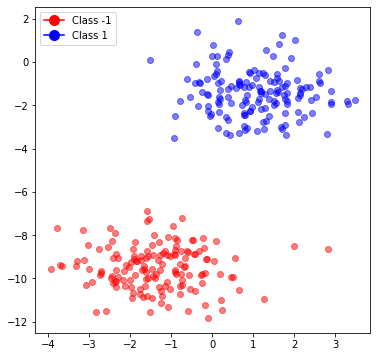

In [9]:
fig = plt.figure(figsize=(6,6))

# plot negatives in red
plt.scatter(X[y==-1,0], \
            X[y==-1,1], \
            alpha = 0.5,\
            c = 'red')

# and positives in blue
plt.scatter(x=X[y==1,0], \
            y=X[y==1,1], \
            alpha = 0.5, \
            c = 'blue')

P=+1
N=-1
legend_elements = [ Line2D([0], [0], marker='o', color='r',\
                    label='Class %d'%N, markerfacecolor='r',\
                    markersize=10),\
                    Line2D([0], [0], marker='o', color='b',\
                    label='Class %d'%P, markerfacecolor='b',\
                    markersize=10) ]

plt.legend(handles=legend_elements, loc='best')
plt.show()      


## <font style="background-color: #f7dc6f">2.3. Let's train the linear regressor and plot the loss curve</font>


Final weight:
 [9.2112322  1.00413065 1.77223222]

Final loss:
 0.0019394153078909774


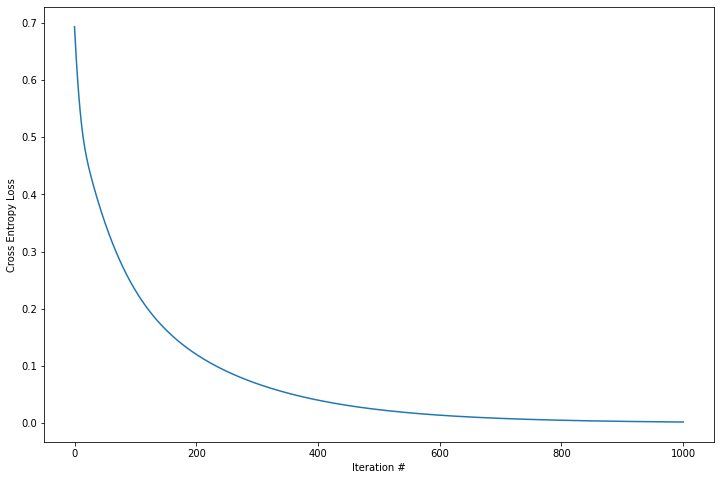

In [76]:
np.random.seed(567)

# ==> Replace the right hand side below with a call to the
# train_logistic() function defined above. Use parameter return_history=True

w_logistic, loss = np.array([0,0,0]), [0]


w_logistic, loss = train_logistic(X, y, learning_rate = 1e-2, w0 = w_logistic,\
                        num_iterations = 1000, return_history = True)
# ==> Your code insert ends here

print()
print("Final weight:\n", w_logistic)
print()
print("Final loss:\n", loss[-1])

plt.figure(figsize = (12, 8))
plt.plot(loss)
plt.xlabel('Iteration #')
plt.ylabel('Cross Entropy Loss')
plt.show()

## 2.4. Now, let's plot the decision boundary

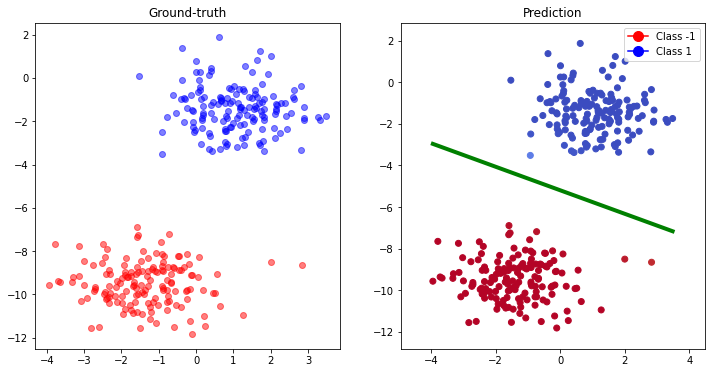

In [73]:
x1min = min(X[:,0])
x1max = max(X[:,0])
x2min = min(X[:,1])
x2max = max(X[:,1])

y_pred = predict_logistic(X, w_logistic)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.set_title("Ground-truth")

# plot negatives in red
ax1.scatter(X[y==-1,0], \
            X[y==-1,1], \
            alpha = 0.5, \
            c = 'red')

# and positives in blue
ax1.scatter(x=X[y==1,0], \
            y=X[y==1,1], \
            alpha = 0.5, \
            c = 'blue')

ax2 = fig.add_subplot(122)

ax2.set_title("Prediction")
ax2.scatter(x = X[:,0], y = X[:,1], c = -y_pred, cmap = 'coolwarm')
ax2.legend(handles=legend_elements, loc='best')
ax2.set_xlim([x1min-1, x1max+1])
ax2.set_ylim([x2min-1, x2max+1])

p1 = (x1min, -(w_logistic[0] + (x1min)*w_logistic[1])/w_logistic[2])
p2 = (x1max, -(w_logistic[0] + (x1max)*w_logistic[1])/w_logistic[2])

lines = ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], '-')
plt.setp(lines, color='g', linewidth=4.0)

plt.show()
        

# 3. Testing on the data we have collected

## 3.1. Read and prepare the dataset 

In [98]:
# load the dataset
df = pd.read_csv('QT1data.csv')
df.head()

,Sex,Age,Height,Weight,Shoe number,Trouser number
0,Female,53,154,59,36,40
1,Male,23,170,56,40,38
2,Female,23,167,63,37,40
3,Male,21,178,78,40,40
4,Female,25,153,58,36,38


In [99]:
df.describe()

,Age,Height,Weight,Shoe number
count,130.000000,130.000000,130.000000,130.000000
mean,28.238462,170.684615,70.238462,39.507692
std,12.387042,11.568491,15.534809,2.973386
min,3.000000,100.000000,15.000000,24.000000
25%,21.000000,164.250000,60.000000,38.000000
50%,23.000000,172.000000,69.500000,40.000000
75%,29.000000,178.000000,80.000000,41.000000
max,62.000000,194.000000,130.000000,46.000000


In [100]:
# Does filtering out the 'children' make any difference ?
#df = df[df['Height']>130]

In [101]:
# Select only features of interest
feature_cols = ['Height', 'Weight']
X = (df.loc[:, feature_cols]).to_numpy(dtype=float)

# Input normalization
for i in range(X.shape[1]):
    avg = np.mean(X[:, i])
    stddev = np.std(X[:, i])
    X[:, i] = (X[:, i] - avg) / stddev

print(X.shape)

(130, 2)


In [102]:
# Our target variable is Sex
sex = df.pop('Sex').values

In [103]:
# convert to negative=-1 and positive=1 using functions from scikit-learn
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(sex)
y = np.where(y==0, -1, y)
print(y.shape)
print(min(y), max(y))

(130,)
-1 1



## <font style="background-color: #f7dc6f">3.2. Training </font>


Final weight:
 [ 1.1100434   2.1588185  -0.07584231]

Final loss:
 0.4262489686476846


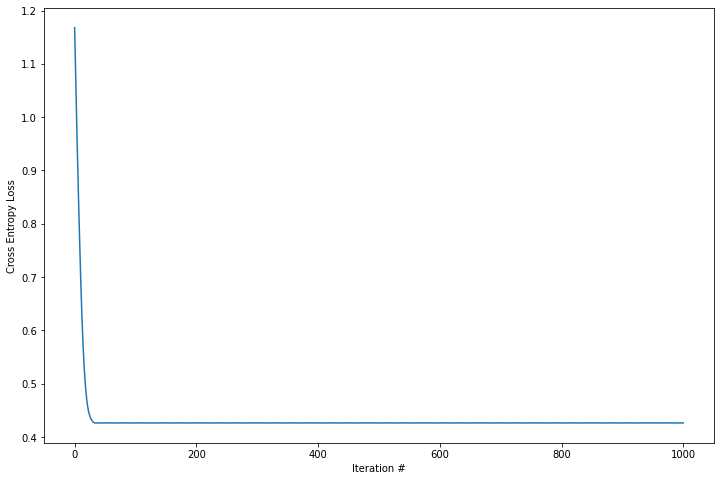

In [104]:
# ===> Write the code for 
#      - training,
w_logistic, loss = train_logistic(X, y, learning_rate = 1e-1,\
                        num_iterations = 1000, return_history = True)

print()
#      - printing the final weight vector
print("Final weight:\n", w_logistic)
print()
print("Final loss:\n", loss[-1])

plt.figure(figsize = (12, 8))
#      - plotting the loss curve
plt.plot(loss)
plt.xlabel('Iteration #')
plt.ylabel('Cross Entropy Loss')
plt.show()




## <font style="background-color: #f7dc6f">3.3. Ploting the ground-truth, prediction + decision boundary</font>

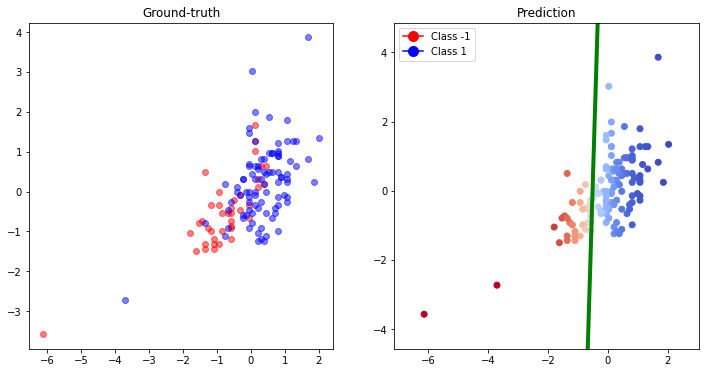

In [105]:
# ===> Write the code for
#      - computing the prediction
#      - plotting the scatterplot with the ground-truth 
#        and another with the prediction and decision boundary line


x1min = min(X[:,0])
x1max = max(X[:,0])
x2min = min(X[:,1])
x2max = max(X[:,1])

y_pred = predict_logistic(X, w_logistic)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.set_title("Ground-truth")

# plot negatives in red
ax1.scatter(X[y==-1,0], \
            X[y==-1,1], \
            alpha = 0.5, \
            c = 'red')

# and positives in blue
ax1.scatter(x=X[y==1,0], \
            y=X[y==1,1], \
            alpha = 0.5, \
            c = 'blue')

ax2 = fig.add_subplot(122)

ax2.set_title("Prediction")
ax2.scatter(x = X[:,0], y = X[:,1], c = -y_pred, cmap = 'coolwarm')
ax2.legend(handles=legend_elements, loc='best')
ax2.set_xlim([x1min-1, x1max+1])
ax2.set_ylim([x2min-1, x2max+1])

p1 = (x1min, -(w_logistic[0] + (x1min)*w_logistic[1])/w_logistic[2])
p2 = (x1max, -(w_logistic[0] + (x1max)*w_logistic[1])/w_logistic[2])

lines = ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], '-')
plt.setp(lines, color='g', linewidth=4.0)

plt.show()

## <font style="background-color: #f7dc6f">3.4 How good is the separation?</font>

Based on the predicted probabilities, we can decide the final class label for each example $\mathbf{x}$ as follows:

$$\mbox{class label of $\mathbf{x}$} = \left\{
\begin{array}{ll}
+1, & \mbox{if $\hat{P}(y=1|\mathbf{x}) > 0.5$,}\\
-1, & \mbox{if $\hat{P}(y=1|\mathbf{x}) \leq 0.5$}\\
\end{array}
\right.$$

In [114]:
# ===> write your code to compute how many wrong
#      classifications we would have if we use the decision rule above

y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = -1

print(f"We would misclassfy {np.count_nonzero(y_pred != y)} out of {y.size} points")

We would misclassfy 20 out of 130 points


## 3.4 Repeat for $d>2$ variables

In this case, there is no need to display the scatter plot.

(Just for fun)

In [ ]:
# ===> Your code

# 4. MNIST Dataset 

This is a well known dataset, commonly used as a first example to illustrate image classification tasks. We could say it is the "Hello world!" of image classification. It consists of handwritten digits, divided into $60000$ training images and $10000$ test images. All images are gray-scale (one channel with pixel intensities varying from 0 to 255) and have size $28 \times 28$. There are 10 classes, corresponding to digits 0 to 9.

We could use the $28 \times 28$ pixel intensities as features. However, here we will perform feature extraction from the images and then the classification based on the extracted features.

The dataset is available in many places. Here we will use the one available   with Keras [1]. 
More information on MNIST can be found at the [oficial site](http://yann.lecun.com/exdb/mnist/).

[1]: François Chollet and others, Keras, https://keras.io, 2015

## 4.1. Getting and inspecting the data

In [115]:
(X_train_all, y_train_all), (X_test_all, y_test_all) = mnist.load_data()

print(X_train_all.shape, y_train_all.shape)
print(X_test_all.shape, y_test_all.shape)

11493376/11490434 [==============================] - 16s 1us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


#### Class distribution of MNIST (training set)


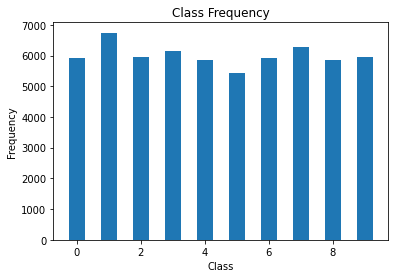

In [116]:
unique, counts = np.unique(y_train_all, return_counts=True)
plt.bar(unique, counts, 0.5)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### <font style="background-color: #f7dc6f">Class distribution of MNIST (test set)</font>
Repeat **Class distribution of MNIST** for the testing set (next cell) and compare and comment about the distributions of the training and of the testing sets. Do you think this type of comparison is important? Comment.

===> Your comments here

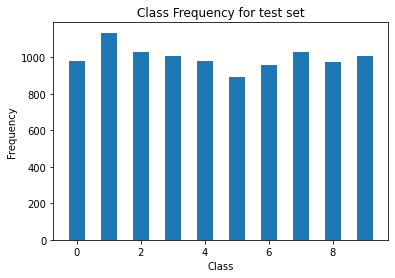

In [119]:
# ===> Your code here
unique, counts = np.unique(y_test_all, return_counts=True)
plt.bar(unique, counts, 0.5)
plt.title('Class Frequency for test set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

"""
this comparison is important because we're trying to guarantee that our model generalizes well. Because the train
and test set follow almost the same distribution, we know the model wasn't fed biased train data and could
generalize well.
"""

#### Visualization of some of the examples

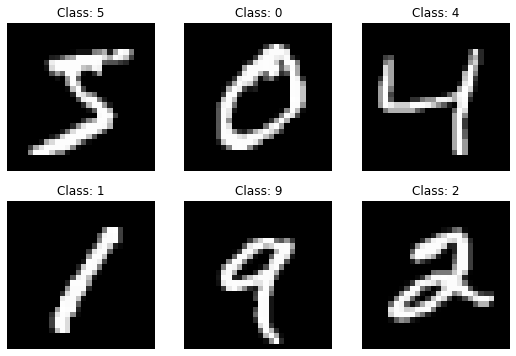

In [117]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train_all[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_all[i])
    
plt.show()

## 4.2. Feature extraction

Note that the images consist of 28×28=784 pixel values and they could be used as "raw features" of the images. However, here we will extract some features from the images and perform classification using them instead of the pixel values.

### Mean intensity

In the book _Learning from Data_ [2], one of the attributes (features) used by the authors is the mean intensity of the pixel values. This feature is directly related to the proportion of the pixels corresponding to the digit in the image. For instance, it is reasonable to expect that a digit 5 or 2 occupies more pixels than the digit 1 and, therefore, the mean intensity of the first two should be larger than that of the digit 1.

### Symmetry

The second attribute used by the authors is horizontal symmetry.

Symmetry will be defined in terms of asymetry. We define asymmetry as the pixelwise mean of the absolute difference between the pixels values from the original image and those from the corresponding horizotally flipped image. Then, symmetry is defined as the negative of asymmetry.

[2]: Yaser S Abu-Mostafa, Malik Magdon-Ismail, and Hsuan-Tien Lin, Learning from Data, 2012

In [120]:
def mean_intensity(image):
    return np.mean(image)

def Hsimmetry(image):
    # The processing below invert the order of the columns of the image
    reflected_image = image[:, ::-1]
    return -np.mean(np.abs(image - reflected_image))

### Pixels $\rightarrow$ Features ##

The above functions for feature extraction will be applied to the samples, both on the training and the test sets. After the feature extraction process below, each image will be represented by two features.

In [121]:
# Function that converts an image into a list of features,
# using the feature computation functions defined above
def convert2features(image):
    return np.array([mean_intensity(image),
                     Hsimmetry(image)])

# feature names
F = ['Mean intensity', 'Hsimmetry']

# Generate the feature representation for all images
X_train_features = np.array([convert2features(image) for image in X_train_all])
X_test_features  = np.array([convert2features(image) for image in X_test_all])

print(X_train_features.shape)
print(X_test_features.shape)

for i in range(0,X_train_features.shape[1]):
    print()
    print("Mean of '%s' = %f" \
          %(F[i],np.mean(X_train_features[:, i])))

(60000, 2)
(10000, 2)

Mean of 'Mean intensity' = 33.318421

Mean of 'Hsimmetry' = -32.617796


**Normalization** of feature values is a common procedure. Here we apply the z-score formula. Note that the normalization parameters (mean and standard deviation) are computed only on training data. To normalize the test data, we use the same parameters.
(We suggest you to think why we should not compute the mean and standard deviation over the training+test set. There is no need to answer this here.)

In [122]:
# Adjust the scale of feature values; standardize them.
# (Yes, the features in the test set should be standardized using
#  the statistics of the features in the training set) -- why ??
for i in range(X_train_features.shape[1]):
    avg = np.mean(X_train_features[:, i])
    stddev = np.std(X_train_features[:, i])
    X_train_features[:, i] = (X_train_features[:, i] - avg) / stddev
    X_test_features[:, i] = (X_test_features[:, i] - avg) / stddev

print("Shape of X_train: ", X_train_features.shape)
print("Shape of X_test: ", X_test_features.shape)

# print the mean value of each of the features
print()
print("Training set, after normalization:")
for i in range(0,X_train_features.shape[1]):
    print("  Mean value of '%s' = %f" \
          %(F[i],np.mean(X_train_features[:, i])))
    
print()
print("Testing set, after normalization:")
for i in range(0,X_test_features.shape[1]):
    print("  Mean value of '%s' = %f" \
          %(F[i],np.mean(X_test_features[:, i])))

Shape of X_train:  (60000, 2)
Shape of X_test:  (10000, 2)

Training set, after normalization:
  Mean value of 'Mean intensity' = -0.000000
  Mean value of 'Hsimmetry' = -0.000000

Testing set, after normalization:
  Mean value of 'Mean intensity' = 0.042822
  Mean value of 'Hsimmetry' = 0.020592


## 4.3 Logistic regression training and testing


### 4.3.1 Select a subset from two of the classes

Here we select two classes as well as a subset of the examples in each class. All code from here on will use the selected subset. You may change later the selected classes and the number of samples in each class.

#### First, let us select two classes

In [123]:
P = 5  # positive class
N = 1  # negative class

X_train_P = X_train_features[y_train_all == P]
X_train_N = X_train_features[y_train_all == N]
y_train_P = y_train_all[y_train_all == P]
y_train_N = y_train_all[y_train_all == N]

X_test_P = X_test_features[y_test_all == P]
X_test_N = X_test_features[y_test_all == N]
y_test_P = y_test_all[y_test_all == P]
y_test_N = y_test_all[y_test_all == N]

print("Positive class: ", X_train_P.shape, y_train_P.shape)
print("Negative class: ", X_train_N.shape, y_train_N.shape)

Positive class:  (5421, 2) (5421,)
Negative class:  (6742, 2) (6742,)


### <font style="background-color: #f7dc6f">Now we will select a subset of examples from each of the two classes</font>

In the following cell, write where it is indicated by <tt>===></tt> the code to change the label of the positive class to +1 and of the negative class to -1

In [141]:
# Number of positives and negatives to be effectively considered
# in the training data to be explored in the remainder of this notebook
nP = 100
nN = 100

X_train = np.concatenate([X_train_P[:nP], X_train_N[:nN]], axis = 0)
y_train = np.concatenate([y_train_P[:nP], y_train_N[:nN]], axis = 0).astype('float32')

X_test = np.concatenate([X_test_P, X_test_N], axis = 0)
y_test = np.concatenate([y_test_P, y_test_N], axis = 0).astype('float32')


# ===> Change positive class label to +1 and negative class label to -1

y_test[y_test == P] = 1
y_test[y_test == N] = -1
### Your code insert ends here

# Shuffle
np.random.seed(56789)
def shuffle(X, y):
    # input and output must be shuffled equally
    perm = np.random.permutation(len(X))
    return X[perm], y[perm]

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

print("Training X and y --> ", X_train.shape, y_train.shape)
print()
print("Testing X and y --> ", X_test.shape, y_test.shape)

Training X and y -->  (200, 2) (200,)

Testing X and y -->  (2027, 2) (2027,)


#### Plot the selected data

Let us plot the selected subset of data. Negative examples will be plotted in red and positive ones in blue.

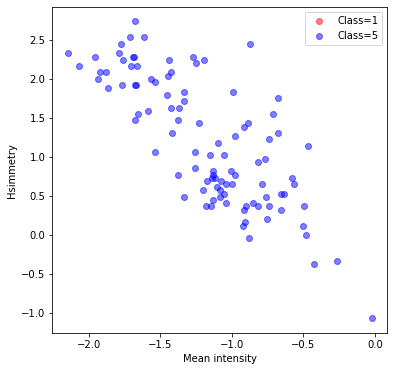

In [143]:
def plot_features(ax,X,y):
    # negatives in red
    ax.scatter(X[y==-1,0], \
               X[y==-1,1], \
               label='Class=%d'%N, c = 'red', alpha = 0.5)

    # and positives in blue
    ax.scatter(x=X[y==1,0], \
               y=X[y==1,1], \
               label='Class=%d'%P, c = 'blue', alpha = 0.5)

    ax.set_xlabel(F[0])
    ax.set_ylabel(F[1])
    ax.legend(loc='best')
    
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plot_features(ax,X_train,y_train)
plt.show()      

### <font style="background-color: #f7dc6f">4.3.2 Training</font>

Run the code in the following cell a few times, each time with different values for  the learning rate and the number of iterations. Comment the behavior of the loss curve. Which values do you consider as good choices?

**Note:** for your submission, keep the execution output corresponding to the best parameter values you have found.
 
===> Your comments here


In [ ]:
np.random.seed(56789)
w_logistic, loss = train_logistic(X_train, y_train,\
                                  learning_rate = 0.005,
                                  num_iterations = 1000,\
                                  return_history = True)

print()
print("Final weight:\n", w_logistic)
print()
print("Final loss:\n", loss[-1])

plt.figure(figsize = (12, 8))
plt.plot(loss)
plt.xlabel('Iteration #')
plt.ylabel('Cross Entropy')
plt.show()

#### Ploting the scores and decision boundary graphs (training set)

In [ ]:
x1min = min(X_train[:,0])
x1max = max(X_train[:,0])
x2min = min(X_train[:,1])
x2max = max(X_train[:,1])

y_pred = predict_logistic(X_train, w_logistic)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.set_title("Ground-truth")

# plot negatives in red
ax1.scatter(X_train[y_train==-1,0], \
            X_train[y_train==-1,1], \
            alpha = 0.5, \
            c = 'red')

# and positives in blue
ax1.scatter(x=X_train[y_train==1,0], \
            y=X_train[y_train==1,1], \
            alpha = 0.5, \
            c = 'blue')

ax2 = fig.add_subplot(122)
ax2.set_title("Prediction+decision boundary")

ax2.scatter(x = X_train[:,0], y = X_train[:,1], c = -y_pred, cmap = 'coolwarm')
ax2.legend(handles=legend_elements, loc='best')

ax2.set_xlim([x1min-0.5, x1max+0.5])
ax2.set_ylim([x2min-0.5, x2max+0.5])

p1 = (x1min, -(w_logistic[0] + (x1min)*w_logistic[1])/w_logistic[2])
p2 = (x1max, -(w_logistic[0] + (x1max)*w_logistic[1])/w_logistic[2])

lines = ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], '-')
plt.setp(lines, color='g', linewidth=4.0)

plt.show()

### <font style="background-color: #f7dc6f">Confusion matrix (training set)</font>

Recall that the logistic regression returns a score $\hat{p}$ in $[0,1]$, which can be interpreted as the probability $p(y=1|\mathbf{x})$. To compute the confusion matrix, one needs to choose a threshold value $T$ to decide the final class label (that is  $\hat{y} = 1 \Longleftrightarrow \hat{p} \geq T$ ).

Play with the threshold value in the code (following cell). Did you manage to find a threshold value (other than 0.5) that improves accuracy? How threshold relates to TP, FP, TN and FN ? Comment.

===> Your comment here

In [ ]:
def plot_confusion_matrix(y, y_pred):
    """
    It receives an array with the ground-truth (y)
    and another with the prediction (y_pred), both with binary labels
    (positve=+1 and negative=-1) and plots the confusion
    matrix.
    It uses P (positive class id) and N (negative class id)
    which are "global" variables ...
    """
    TP = np.sum((y_pred == 1) * (y == 1))
    TN = np.sum((y_pred == -1) * (y == -1))

    FP = np.sum((y_pred == 1) * (y == -1))
    FN = np.sum((y_pred == -1) * (y == 1))

    total = TP+FP+TN+FN
    print("TP = %4d    FP = %4d\nFN = %4d    TN = %4d"%(TP,FP,FN,TN))
    print("Accuracy = %d / %d (%f)\n" %((TP+TN),total, (TP+TN)/total))
    confusion = [
        [TP/(TP+FN), FP/(TN+FP)],
        [FN/(TP+FN), TN/(TN+FP)]
    ]

    df_cm = pd.DataFrame(confusion, \
                         ['$\hat{y} = %d$'%P, '$\hat{y} = %d$'%N],\
                         ['$y = %d$'%P, '$y = %d$'%N])
    plt.figure(figsize = (8,4))
    sb.set(font_scale=1.4)
    sb.heatmap(df_cm, annot=True) #, annot_kws={"size": 16}, cmap = 'coolwarm')
    plt.show()
    
    
threshold = 0.5

p_hat = predict_logistic(X_train, w_logistic)
y_hat = np.where(p_hat > threshold, 1, -1)

total = len(y_hat)

plot_confusion_matrix(y_train, y_hat)   

### <font style="background-color: #f7dc6f">4.3.3. Testing</font>

Now that you have trained the algorithm, let us evaluate its performance on the test set. Plot the scatter plot graphs (as above) and the confusion matrix (using <tt>threshold=0.5</tt>). Do you think the algorithm is doing a good generalization? Comment.</font>

===> Your comment here

In [ ]:
# ===> Your code for the scatter plot (test set)


In [ ]:
# ===> your code for the confusion matrix (test set)


## Extra (optional)

- If you got to this point, make a copy of your notebook.
Run the <i>copy notebook</i> changing the number of positive and negative examples in the MNIST case. Try an unbalanced training set and observe if there are any effects in the accuracy on the test set. Additionaly, you may try with a different pair of classes. If you wish, you can summarize HERE the experiments you did and comment whatever you found interesting. There is no need to submit the <i>copy notebook</i>.</font>

- You can also compare the results obtained with your algorithm with the ones generated by a standard implementation like the one in the scikit-learn library

===> Your comments here

### Remarks

The organization of the code in this notebook does not follow the principles of good programming. For instance, a same piece of code is used repeatedly in several places, the same variable name is used to keep data of different nature, and so on.
